# 2022-05-02• STA mean vs peak-to-peak

Peak-to-peak cannot distinguish excitatory vs inhibitory (it's just the height of the bump -- no matter whether it's upwards or downwards).

To do that, we might instead use sth like "either max-median or min-median, whatever's largest in absolute terms".

For now we don't try to detect this difference, and 'cheat' in our code (special-case the inhibitory / ptp case when comparing p-values with α).

## Setup

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltageToMap

[ Info: Precompiling VoltageToMap [b3b8fdc5-3c26-4000-a0c8-f17415fdf48e]


In [5]:
using PyPlot
using VoltageToMap.Plot

[ Info: Precompiling Sciplotlib [61be95e5-9550-4d5f-a203-92a5acbc3116]


## Params

In [6]:
N_excs = [
    4,   # => N_inh = 1
    17,  # Same as in `previous_N_30_input`.
    80,
    320,
    1280,
    5200,  
];

In [7]:
rngseeds = [0, 1, 2, 3, 4];

In [30]:
get_params((N_exc, rngseed, STA_test_statistic)) = ExperimentParams(
    sim = SimParams(
        duration = 10 * minutes,
        imaging = get_VI_params_for(cortical_RS, spike_SNR = Inf),
        input = PoissonInputParams(; N_exc);
        rngseed,
    ),
    conntest = ConnTestParams(; STA_test_statistic, rngseed);
    evaluation = EvaluationParams(; rngseed)
);

In [31]:
variableparams = collect(product(N_excs, rngseeds, ["ptp", "mean"]))

6×5×2 Array{Tuple{Int64, Int64, String}, 3}:
[:, :, 1] =
 (4, 0, "ptp")     (4, 1, "ptp")     …  (4, 3, "ptp")     (4, 4, "ptp")
 (17, 0, "ptp")    (17, 1, "ptp")       (17, 3, "ptp")    (17, 4, "ptp")
 (80, 0, "ptp")    (80, 1, "ptp")       (80, 3, "ptp")    (80, 4, "ptp")
 (320, 0, "ptp")   (320, 1, "ptp")      (320, 3, "ptp")   (320, 4, "ptp")
 (1280, 0, "ptp")  (1280, 1, "ptp")     (1280, 3, "ptp")  (1280, 4, "ptp")
 (5200, 0, "ptp")  (5200, 1, "ptp")  …  (5200, 3, "ptp")  (5200, 4, "ptp")

[:, :, 2] =
 (4, 0, "mean")     (4, 1, "mean")     …  (4, 4, "mean")
 (17, 0, "mean")    (17, 1, "mean")       (17, 4, "mean")
 (80, 0, "mean")    (80, 1, "mean")       (80, 4, "mean")
 (320, 0, "mean")   (320, 1, "mean")      (320, 4, "mean")
 (1280, 0, "mean")  (1280, 1, "mean")     (1280, 4, "mean")
 (5200, 0, "mean")  (5200, 1, "mean")  …  (5200, 4, "mean")

In [32]:
paramsets = get_params.(variableparams);
print(summary(paramsets))

6×5×2 Array{ExperimentParams, 3}

In [33]:
dumps(paramsets[1])

ExperimentParams
  sim: SimParams
    duration: 600.0
    Δt: 0.0001
    num_timesteps: 6000000
    rngseed: 0
    input: PoissonInputParams
      N_unconn: 100
      N_exc: 4
      N_inh: 1
      N_conn: 5
      N: 105
      spike_rates: LogNormal
        μ: 1.08629
        σ: 0.774597
    synapses: SynapseParams
      avg_stim_rate_exc: 1.0e-10
      avg_stim_rate_inh: 4.0e-10
      E_exc: 0.0
      E_inh: -0.065
      g_t0: 0.0
      τ: 0.007
    izh_neuron: IzhikevichParams
      C: 1.0e-10
      k: 7.0e-7
      v_rest: -0.06
      v_thr: -0.04
      a: 30.0
      b: -2.0e-9
      v_peak: 0.035
      v_reset: -0.05
      Δu: 1.0e-10
      v_t0: -0.06
      u_t0: 0.0
    imaging: VoltageImagingParams
      spike_SNR: Inf
      spike_SNR_dB: Inf
      spike_height: 0.095
      σ_noise: 0.0
  conntest: ConnTestParams
    STA_window_length: 0.1
    num_shuffles: 100
    STA_test_statistic: ptp
    rngseed: 0
  evaluation: EvaluationParams
    α: 0.05
    num_tested_neurons_per_group: 4

## Run

In [34]:
perfs = similar(paramsets, NamedTuple)
for i in eachindex(paramsets)
    (N_exc, seed, STA_test_statistic) = variableparams[i]
    paramset = paramsets[i]
    println((; N_exc, seed, STA_test_statistic), " ", cachefilename(paramset))
    perf = cached(sim_and_eval, [paramset])
    perfs[i] = perf
end

(N_exc = 4, seed = 0, STA_test_statistic = "ptp") 1c6eb51735c61aa7.jld2
(N_exc = 17, seed = 0, STA_test_statistic = "ptp") 84d27a020097a66c.jld2
(N_exc = 80, seed = 0, STA_test_statistic = "ptp") 4f790c694d38d1ea.jld2
(N_exc = 320, seed = 0, STA_test_statistic = "ptp") 12abb647d0323d89.jld2
(N_exc = 1280, seed = 0, STA_test_statistic = "ptp") da749dd4f62b2c79.jld2
(N_exc = 5200, seed = 0, STA_test_statistic = "ptp") 8d7b02d80d95564a.jld2
(N_exc = 4, seed = 1, STA_test_statistic = "ptp") a4336b934de51319.jld2
(N_exc = 17, seed = 1, STA_test_statistic = "ptp") bd9d2af9ae7399e7.jld2
(N_exc = 80, seed = 1, STA_test_statistic = "ptp") 1b7dbae8b12724a9.jld2
(N_exc = 320, seed = 1, STA_test_statistic = "ptp") 24eed4ff47bd2d9c.jld2
(N_exc = 1280, seed = 1, STA_test_statistic = "ptp") bb7c4b6a0bafba5b.jld2
(N_exc = 5200, seed = 1, STA_test_statistic = "ptp") 646d120436b18997.jld2
(N_exc = 4, seed = 2, STA_test_statistic = "ptp") 389be050ca350439.jld2
(N_exc = 17, seed = 2, STA_test_statistic = 

Testing connections: 100%|██████████████████████████████| Time: 0:00:08
Saving output at `C:\Users\tfiers\.phdcache\sim_and_eval\d12f89555011a0ed.jld2` …  done
(N_exc = 17, seed = 4, STA_test_statistic = "mean") 8e3a970eff73f05a.jld2
Testing connections: 100%|██████████████████████████████| Time: 0:00:11
Saving output at `C:\Users\tfiers\.phdcache\sim_and_eval\8e3a970eff73f05a.jld2` …  done
(N_exc = 80, seed = 4, STA_test_statistic = "mean") 834639974693e5c7.jld2
Testing connections: 100%|██████████████████████████████| Time: 0:00:17
Saving output at `C:\Users\tfiers\.phdcache\sim_and_eval\834639974693e5c7.jld2` …  done
(N_exc = 320, seed = 4, STA_test_statistic = "mean") 51ca4fbab5743fe5.jld2
Testing connections: 100%|██████████████████████████████| Time: 0:00:20
Saving output at `C:\Users\tfiers\.phdcache\sim_and_eval\51ca4fbab5743fe5.jld2` …  done
(N_exc = 1280, seed = 4, STA_test_statistic = "mean") 52da32c9d00a151.jld2
Testing connections: 100%|██████████████████████████████| Time

- `sim` cache (10' x 6 N x 4 seeds): 3GB
    - 95 à 142MB per 10' sim
- `perf` cache: 0.3MB -- so that could go in git

In [38]:
perfs

6×5×2 Array{NamedTuple, 3}:
[:, :, 1] =
 (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.0)      …  (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.05)
 (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.05)        (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.075)
 (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.05)        (TPR_exc = 1.0, TPR_inh = 0.85, FPR = 0.0)
 (TPR_exc = 1.0, TPR_inh = 0.725, FPR = 0.05)      (TPR_exc = 1.0, TPR_inh = 0.7, FPR = 0.0)
 (TPR_exc = 0.775, TPR_inh = 0.5, FPR = 0.1)       (TPR_exc = 0.775, TPR_inh = 0.475, FPR = 0.075)
 (TPR_exc = 0.075, TPR_inh = 0.075, FPR = 0.1)  …  (TPR_exc = 0.025, TPR_inh = 0.05, FPR = 0.1)

[:, :, 2] =
 (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.075)     …  (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.1)
 (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.05)         (TPR_exc = 1.0, TPR_inh = 1.0, FPR = 0.05)
 (TPR_exc = 1.0, TPR_inh = 0.9, FPR = 0.025)        (TPR_exc = 1.0, TPR_inh = 0.7, FPR = 0.15)
 (TPR_exc = 0.95, TPR_inh = 0.375, FPR = 0.1)       (TPR_exc = 0.975, TPR_inh = 0.425, FPR =

## Prepare plot

We want to plot dots.
We can either have  
`N = [5, 21]`  
and `TPR_exc = [1 .9 1; .8 .7 .8]` (matrix notation. 3 seeds).  
or  
`N = [5, 5, 5, 21, 21, 21]` (i.e. repeat)  
and `TPR_exc = [1, .9, 1, .8, .7, .8]`.

In [39]:
"""
Create an array of the same shape as the one given,
but with just the values stored under `name`
in each element of the given array.
"""
function extract(name::Symbol, arr #=an array of NamedTuples or structs =#)
    getval(index) = getproperty(arr[index], name)
    out = similar(arr, typeof(getval(firstindex(arr))))
    for index in eachindex(arr)
        out[index] = getval(index)
    end
    return out
end;

In [40]:
extract(:TPR_exc, perfs)

6×5×2 Array{Float64, 3}:
[:, :, 1] =
 1.0    1.0   1.0    1.0    1.0
 1.0    1.0   1.0    1.0    1.0
 1.0    1.0   1.0    1.0    1.0
 1.0    1.0   1.0    1.0    1.0
 0.775  0.8   0.825  0.725  0.775
 0.075  0.05  0.05   0.075  0.025

[:, :, 2] =
 1.0    1.0    1.0    1.0    1.0
 1.0    1.0    1.0    1.0    1.0
 1.0    1.0    1.0    1.0    1.0
 0.95   0.925  0.85   0.95   0.975
 0.575  0.625  0.575  0.725  0.825
 0.05   0.025  0.15   0.15   0.1

In [41]:
import PyPlot

In [42]:
using VoltageToMap.Plot

In [45]:
function make_figure(perfs)
    xticklabels = [p.sim.input.N_conn for p in paramsets[:,1,1]]
    xs = [1:length(xticklabels);]
    fig, ax = plt.subplots()
    plot_detection_rate(rate; kw...) = plot_samples_and_means(xs, rate, ax; kw...)
    plot_detection_rate(extract(:TPR_exc, perfs), label="for excitatory inputs", c=color_exc)
    plot_detection_rate(extract(:TPR_inh, perfs), label="for inhibitory inputs", c=color_inh)
    plot_detection_rate(extract(:FPR, perfs), label="for unconnected spikers", c=color_unconn)
    
    set(ax; xtype=:categorical, ytype=:fraction, xticklabels, xlabel="Number of connected inputs")
    
    add_α_line(ax, paramsets[1].evaluation.α)
    
    l = ax.legend(title="Detection rate", ncol=2, loc="lower right", bbox_to_anchor=(1.06, 1.1))
    l._legend_box.align = "left"
    return fig, ax
end;

## Plot

### Peak-to-peak

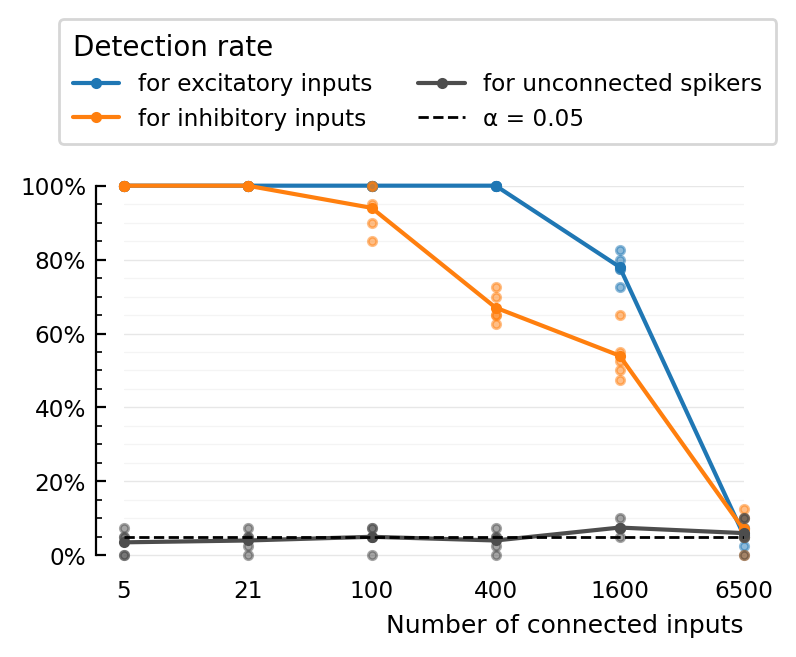

In [46]:
fig, ax = make_figure(perfs[:,:,1]);

### Mean

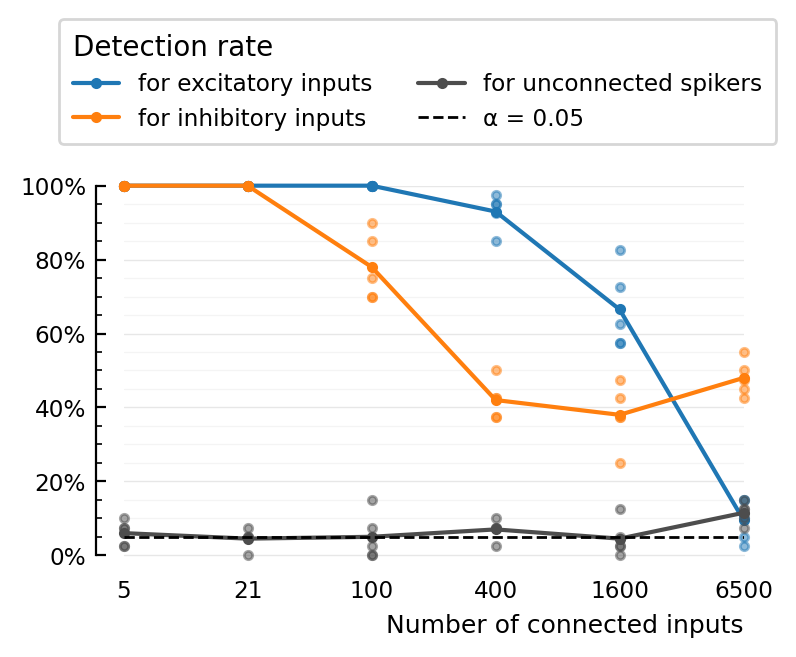

In [47]:
fig, ax = make_figure(perfs[:,:,2]);